In [1]:
%matplotlib inline 

import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import c

from axiprop.utils import laser_from_fu, mirror_parabolic
from axiprop.lib import PropagatorFFT2

In [2]:
lambda0 = 0.8e-6              # wavelength [m]
tau_fwhm = 35e-15             # FWHM duration (intensity) [s]
R_las = 10e-3                 # Radial size of laser [m]

tau = tau_fwhm / (2*np.log(2))**0.5
k0 = 2 * np.pi / lambda0

def fu_laser(kz, r):
    """
    Gaussian spot with the Gaussian temporal profile
    """
    profile_r = np.exp( -(r/R_las)**2 ) * (r<2.5*R_las)
    profile_kz = np.exp( -( (kz-k0) * c * tau / 2 )**2 )
    return profile_r * profile_kz

f_N = 400                      # f-number of the parabolic mirror
f0 = 2 * R_las * f_N          # focal length

In [3]:
L_kz = 8 / (c*tau)               # full spectral width [1/s] 
Nkz = 1                          # number of kz modes (1 for quick demonstration)
w0 = 2/np.pi * lambda0 * f_N     # beam waist
L_R = np.pi * w0**2/lambda0      # Rayleigh length

Lx = 5 * R_las               # total radius [m]
Ly = 5 * R_las               # total radius [m]
Nx = 1024*4
Ny = 1024*4

prop = PropagatorFFT2((Lx, Nx), (Ly, Ny), (k0, L_kz, Nkz))

Available backends are: NP, CL, CU
CU is chosen


In [4]:
A0 = laser_from_fu( fu_laser, prop.kz, prop.r, normalize=True )
A0 /=  (R_las/w0) # normalise to the focussed amplitude
A0 = A0 * mirror_parabolic( f0, prop.kz, prop.r )

In [5]:
Nsteps = 32
Distance = 8 * L_R

dz =  Distance / Nsteps
zsteps = Nsteps * [dz,]
zsteps[0] = f0 - Distance/2
z_axis = np.cumsum(zsteps)
R2 = (prop.r/w0)**2

A_multi = prop.steps(A0, zsteps)

  0%|          | 00:00<? [?it/s]

In [6]:
IntesityPropagation = np.zeros((Nsteps, prop.Nx))
waist = np.zeros((Nsteps))

for istep in range(Nsteps):
    val = (np.abs(A_multi[istep,:,prop.Nx//2])**2).sum(0)
    IntesityPropagation[istep,:] = val
    waist[istep] = 2*np.average(np.abs(prop.x/w0)**2, weights=val)**0.5

IntesityPropagation = np.array(IntesityPropagation)
FieldPropagation = IntesityPropagation**0.5

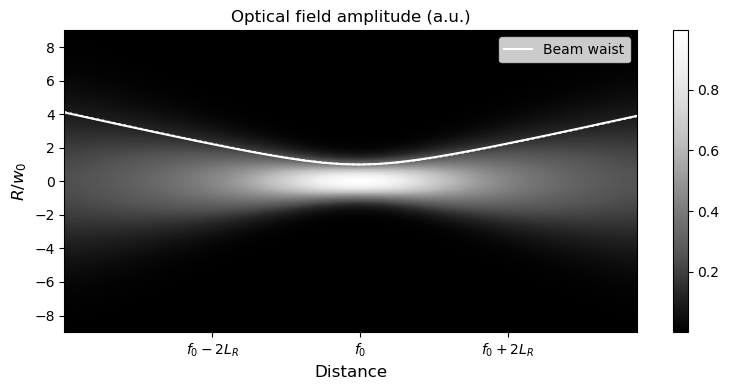

In [7]:
plt.figure(figsize=(8,4), tight_layout=True, dpi=100)

plt.imshow(FieldPropagation.T, 
           extent=[ zsteps[0]/f0, sum(zsteps)/f0, prop.x.min()/w0, prop.x.max()/w0 ],
           aspect='auto', origin='lower', interpolation='gaussian',
           cmap=plt.cm.Greys_r)

plt.colorbar()

plt.plot(z_axis/f0, waist, c='w')
plt.plot(z_axis/f0, ( 1 + ((z_axis-f0)/L_R)**2 )**.5, ':', c='w' )
plt.legend(('Beam waist',))

plt.xticks(np.array([1-2*L_R/f0, 1, 1+2*L_R/f0]), 
           (r'$f_0-2L_R$', r'$f_0$', r'$f_0+2L_R$',))

plt.title('Optical field amplitude (a.u.)',fontsize=12)
plt.xlabel('Distance', fontsize=12)
plt.ylabel('$R/w_0$', fontsize=12);
plt.ylim(-9, 9);